#### Ben Cohen & Stav Yosef 
<br>

### Final project in the class: Information-theoretic analysis of neural language models
#### Recihman University, Fall 2022-2023

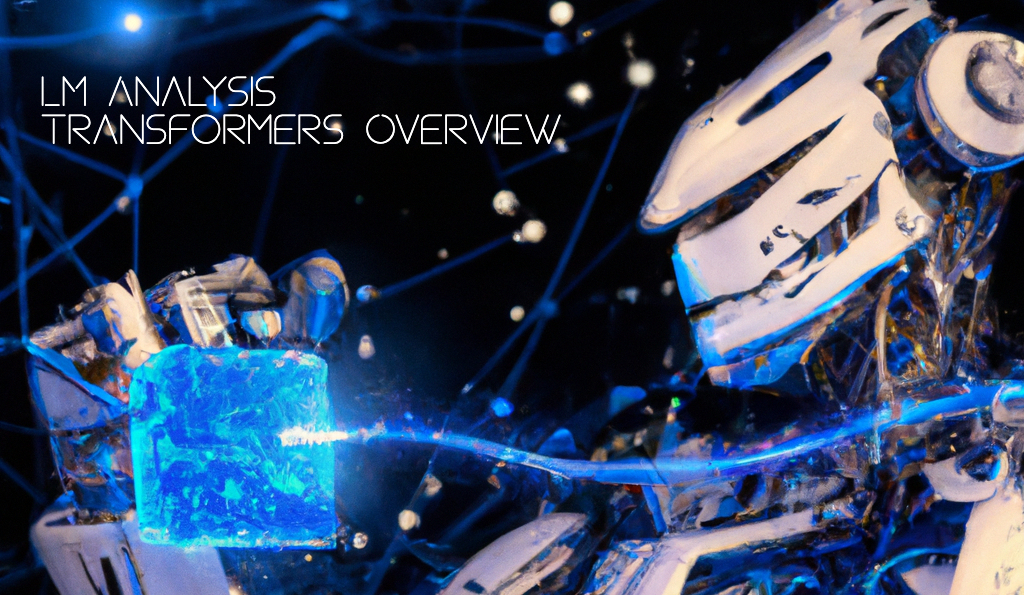

# Table of Content:




1. Introduction: The story from N-Gram to GPT (N-Gram -> RNN/LSTM -> Word2Vec -> Attention -> Transformers -> GPT)
2. Architecture:
  1. Attention / Self-Attention
  2. Tokenization
  3. Encoder-Decoder (Encoder-only models, Decoder-only models, Encoder-decoder/sequence-to-sequence models)
  4. The illustrated transformer
3. Training:
  1. Training objectives
  2. Pretraining
  3. Prompt engineering
4. Code Examples:
  1. Training
  2. Finetune
  3. Distribution of tokens
  4. Cool examples

# Initialization 

In [ ]:
!pip install bertviz
!pip install transformers
!pip install --upgrade --no-cache-dir gdown

!gdown 1_ylE8Q2vXsYRtHnbrlMFo60VpFm60TeB # shortjokes_train.csv
!gdown 1DHKyAY-AfUHtYhNLyinKpT87Ixa1UJTW # shortjokes_test.csv
!pip install gensim

In [ ]:
"""
Imports
"""
import string
import random
import pandas as pd
import numpy as np

# N-Gram
import nltk
from nltk.util import ngrams
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize

# Word2Vec
import gensim
from gensim.models import word2vec
from nltk.data import find

# Attention
from bertviz import head_view, model_view
from transformers import AutoTokenizer, BertTokenizer, BertModel
from transformers import DistilBertTokenizerFast, DistilBertModel

# GPT
import csv
import os
import warnings
from collections import defaultdict
from dataclasses import dataclass
from typing import List

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
# Download
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('reuters')
nltk.download('word2vec_sample')


def generate_sent(model, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

# Introduction: The story from N-Gram to GPT 



## (N-Gram -> RNN/LSTM -> Word2Vec -> Attention -> Transformers -> GPT)

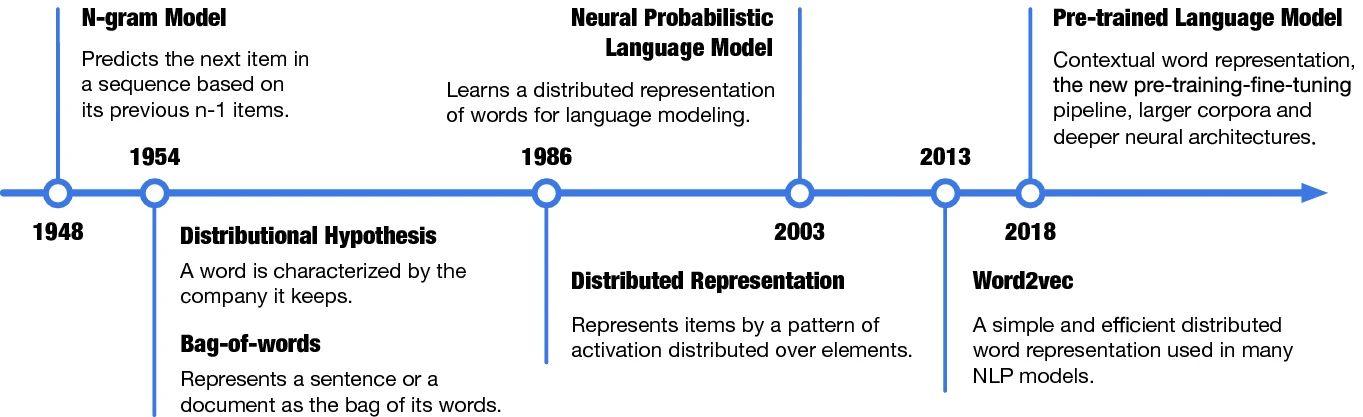

### N-Gram
An N-gram language model predicts the probability of a given N-gram within any sequence of words in the language. A good N-gram model can predict the next word in the sentence i.e the value of $p(w|h)$

In [ ]:
df = pd.read_csv('/content/Donald-Tweets!.csv')
df['Tweet_Text'][:5]

In [ ]:
# Training
N = 3
trump_corpus = list(df['Tweet_Text'].apply(word_tokenize))
train_data, padded_sents = padded_everygram_pipeline(N, trump_corpus)

trump_model = MLE(N)  # 3-grams model
trump_model.fit(train_data, padded_sents)

In [ ]:
generate_sent(trump_model, num_words=100, random_seed=52)

### Distributed Representation
#### The Age of neural networks

Distributed Representation refers to feature creation, in which the features may or may not have any obvious relations to the original input but they have comparative value i.e. similar inputs have similar features.


#### RNN - **R**ecurrent **N**eural **N**etworks



https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Humans don’t start their thinking from scratch every second. As you read this essay, you understand each word based on your understanding of previous words. You don’t throw everything away and start thinking from scratch again. Your thoughts have persistence.

Traditional neural networks can’t do this, and it seems like a major shortcoming. For example, imagine you want to classify what kind of event is happening at every point in a movie. It’s unclear how a traditional neural network could use its reasoning about previous events in the film to inform later ones.
Recurrent neural networks address this issue. They are networks with loops in them, allowing information to persist.

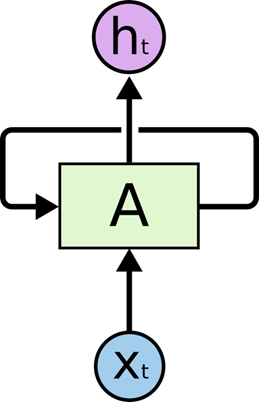

These loops make recurrent neural networks seem kind of mysterious. However, if you think a bit more, it turns out that they aren’t all that different than a normal neural network. A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor. Consider what happens if we unroll the loop

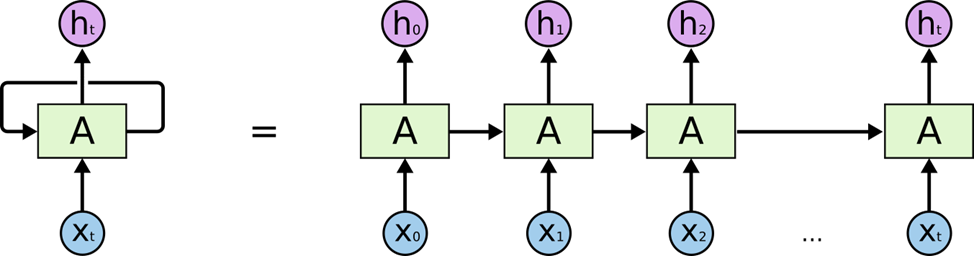

What is the problem with this architecture?

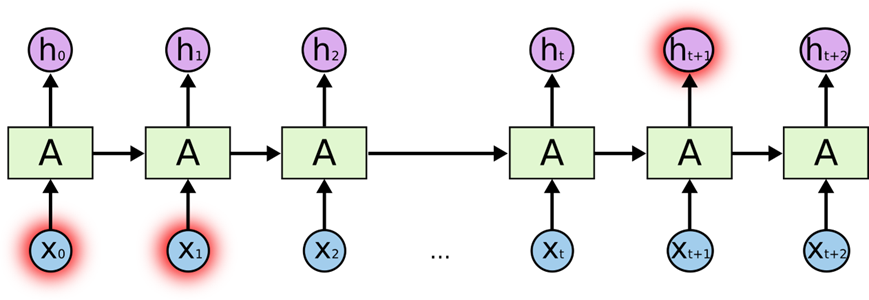

Consider trying to predict the last word in the text “I grew up in France… I speak fluent French.” Recent information suggests that the next word is probably the name of a language, but if we want to narrow down which language, we need the context of France, from further back. It’s entirely possible for the gap between the relevant information and the point where it is needed to become very large.

#### LSTM - **L**ong **S**hort **T**erm **M**emory

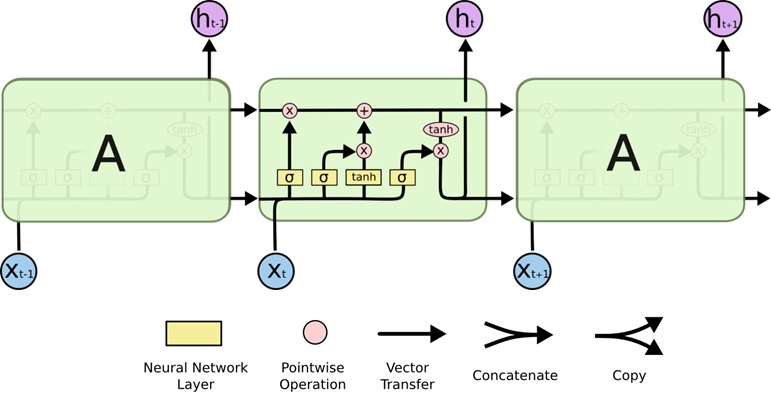

LSTMs are explicitly designed to avoid the long-term dependency problem (RNN’s problem). Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

#### Encoder - Decoder

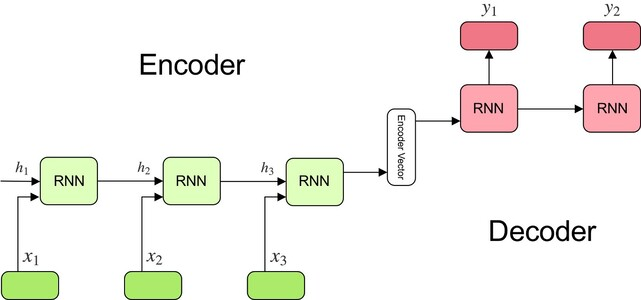

In 2014, Sutskever et al. proposed sequence-to-sequence learning, a general end-to-end approach for mapping one sequence to another using a neural network. 

In their method, an encoder neural network processes a sentence symbol by symbol, and compresses it into a vector representation. Then, a decoder neural network predicts the output sequence symbol by symbol based on the encoder vector and the previously predicted symbols that are taken as input at every step. Encoders and decoders for sequences are typically based on RNNs, but other architectures have also emerged.

The power of this model lies in the fact that it can **map sequences of different lengths to each other**. As you can see the inputs and outputs are not correlated and their lengths can differ. This opens a whole new range of problems which can now be solved using such architecture.

## Word Embedding

### Word2Vec

In 2013, Google introduced Word2Vec. (Mikolov et al., 2013) <br />
<br />
https://jalammar.github.io/illustrated-word2vec/

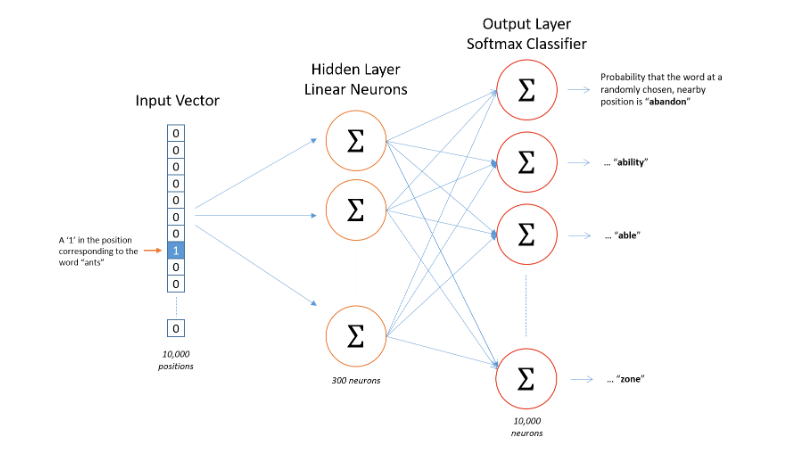

In [ ]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [ ]:
vocab_size = len(word2vec_model.vocab)
vector_size = len(word2vec_model['man'])

print(f'This model has a vocabulary of {vocab_size} words and each word represented by a {vector_size}x1 vector')

In [ ]:
word2vec_model.most_similar('woman')

In [ ]:
print(word2vec_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1))
print(word2vec_model.most_similar(positive=['Paris', 'Germany'], negative=['Berlin'], topn=1))
print('===============================================')
print('')
word2vec_model.most_similar(positive=['go', 'do'], negative=['did'], topn=5)

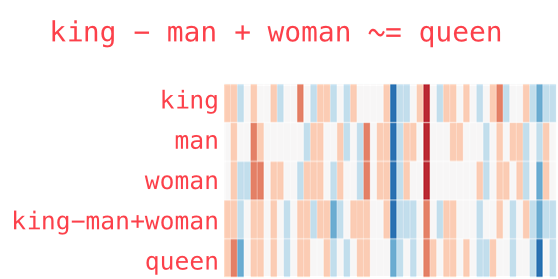

## Attention & Transformers



### The Birth of Attention


There was a problem with RNN\LSTM in which they tend to “forget” what was learnt if the sentences got too long. This was noted as the problem of “long-term dependencies” they can remember sequences of 100s, not 1000s or 10,000s or more.

One more problem was with the encoder-decoder framework which is that the encoder at times is forced to encode information which might not be fully relevant to the task at hand. The problem arises also if the input is long or very information-rich and selective encoding is not possible.

As such, Bahdanau et al. (2015) proposed the attention mechanism to address this issue.

It basically alleviates the main bottleneck of sequence-to-sequence learning, which is its requirement to compress the entire content of the source sequence into a fixed-size vector. Instead Attention used all the hidden states of the encoder (instead of just the last state) in the model at the decoder end. But the best part was - they made the model give particular 'attention' to certain hidden states when decoding each word. They let the model itself 'learn' which words to give Attention to and which ones to ignore during translation of each word at the decoder.

https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/

### The Birth of Transformers -  [Attention is All You Need](https://arxiv.org/abs/1706.03762)




Google proposed a new simple network architecture known as the Transformer. (Vaswani et al., 2017)

This was a paradigm shift from the standard way NLP applications were built upon. i.e. Using RNNs, LSTMs or GRUs initialized with word embeddings.

Vaswani et al. (2017) based the Transformer solely on the attention mechanism (self-attention) which put an end to RNNs entirely.

In self-attention, the concept of attention is used to encode sequences instead of RNNs. So both the encoder and decoder now dont have RNNs and instead use attention mechanisms. In itself simplest form - each word in the sequence attends to every other word in the same sequence and in this way relationship between words in the sequence are captured.

Vaswani et al. (2017) work soon gave birth to the game-changing

Bidirectional Encoder Representations from Transformers a.k.a BERT the next year. (Devlin et al., 2018)

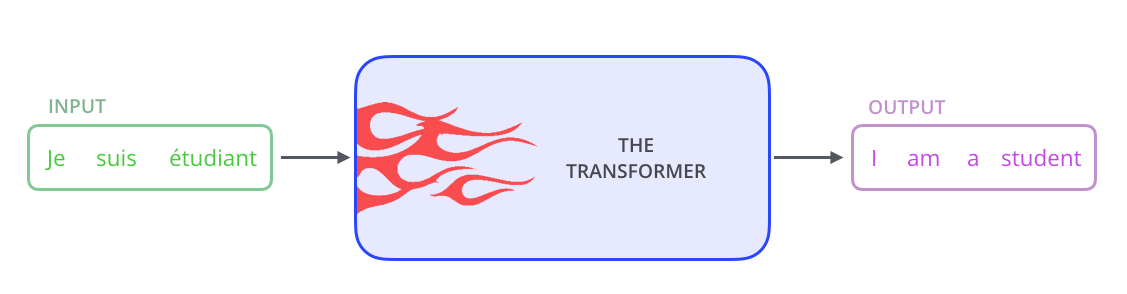

https://jalammar.github.io/illustrated-transformer/

## The Era of Pretrained (Large) Language Models

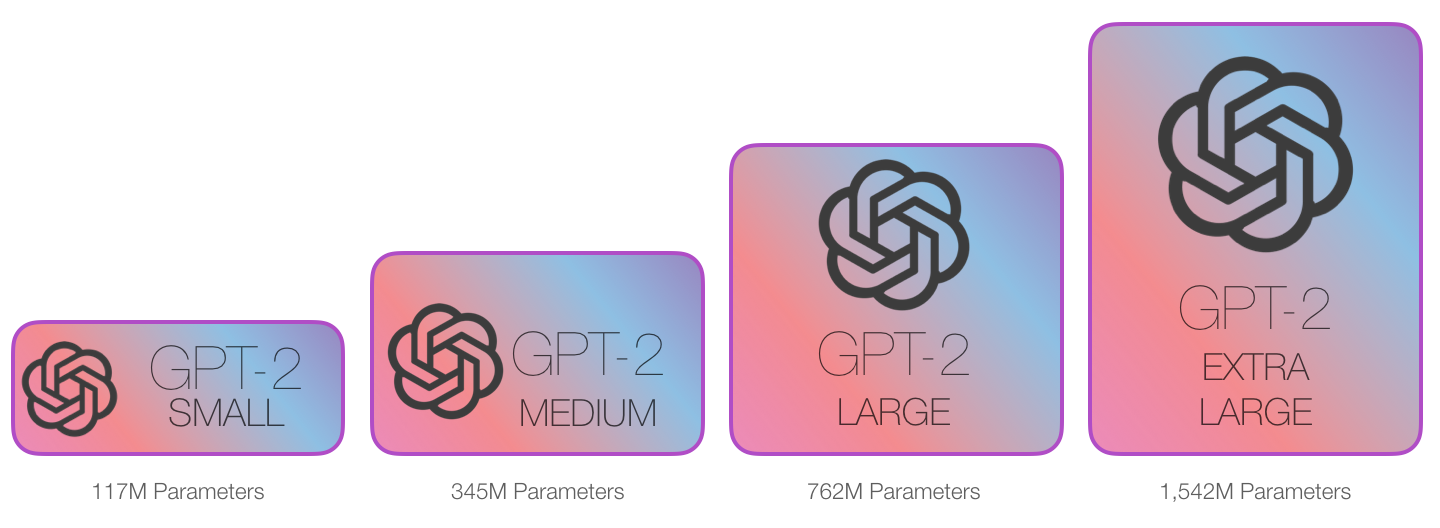

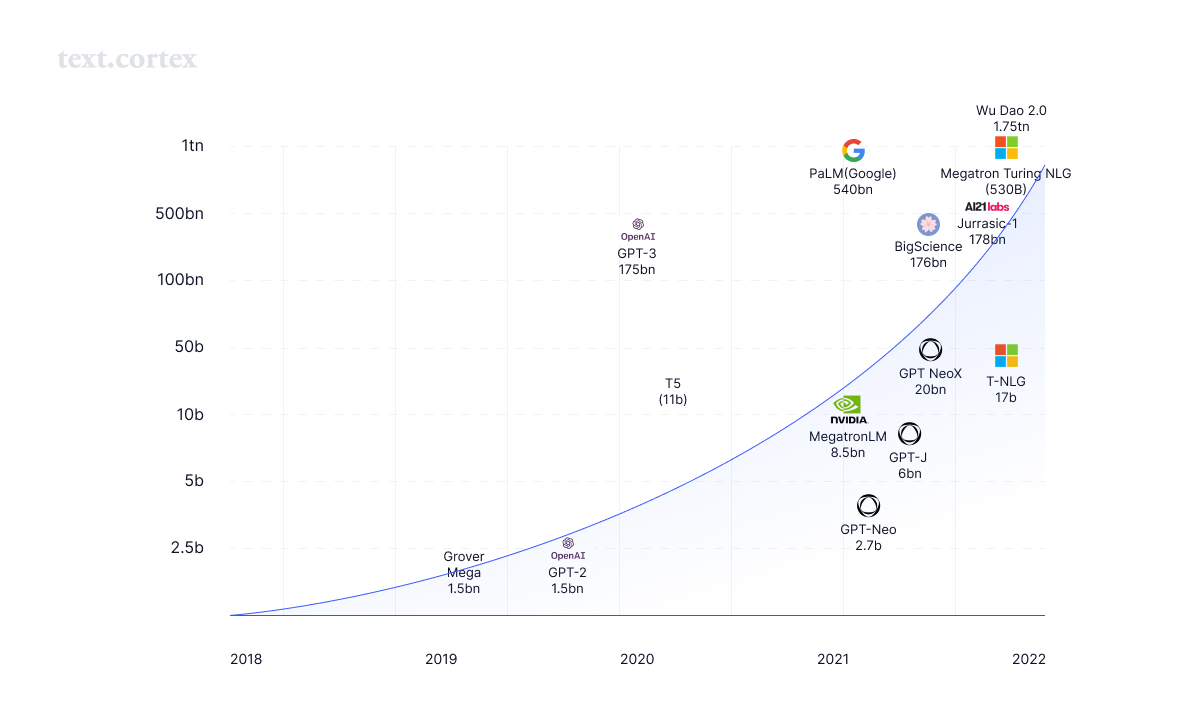

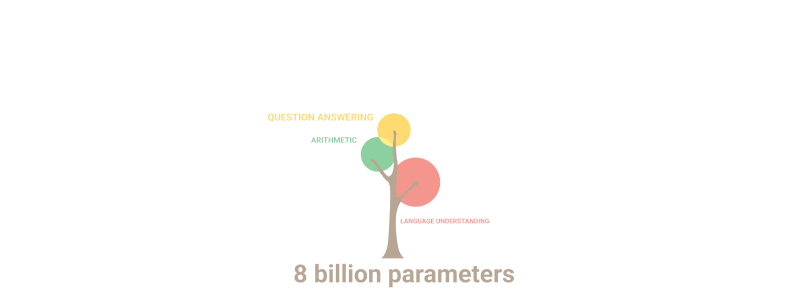

GPT4 should be release in the coming months! the eastimation is talking about **100 trillion parameters**!!!


one billion model weight around 4GB then, 1 trillion is 4TB and 100 triliion is 400TB. rule of thumb to train a nerual network with Adam as an optimizer is 4 times the size of the model hence, around 1600TB (1,600,000GB) of GPUs memory is required.

RTX 3090 contains 24GB, $\frac{1600000}{24}=66,666~$ GPUs.

Does they use this amount of compute power? probably not and we'll explain at the end how it can be done.

[As the scale of the model increases, the performance improves across tasks while also unlocking new capabilities.](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html)

# Architecture

## Self-Attention

First create three vectors from each of the encoder’s input vectors (in this case, the embedding of each word). So for each word, we create a Query vector, a Key vector, and a Value vector. These vectors are created by multiplying the embedding by three matrices that we trained during the training process. <br/>
$q_1 = x_1\times W^Q$ <br/>
$k_1 = x_1\times W^K$ <br/>
$v_1 = x_1\times W^V$ <br/>

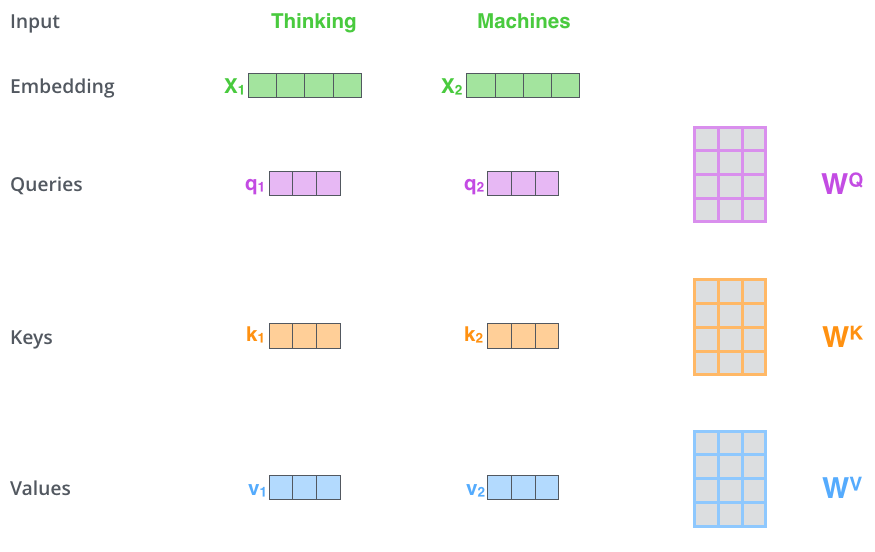

Second step in calculating self-attention is to calculate a score. Say we’re calculating the self-attention for the first word in this example, “Thinking”. We need to score each word of the input sentence against this word. The score determines how much focus to place on other parts of the input sentence as we encode a word at a certain position.

The score is calculated by taking the dot product of the query vector with the key vector of the respective word we’re scoring. So if we’re processing the self-attention for the word in position #1, the first score would be the dot product of q1 and k1. The second score would be the dot product of q1 and k2.

The third and fourth steps are to divide the scores by 8 (the square root of the dimension of the key vectors used in the paper – 64. This leads to having more stable gradients. There could be other possible values here, but this is the default), then pass the result through a softmax operation. Softmax normalizes the scores so they’re all positive and add up to 1.

The fifth step is to multiply each value vector by the softmax score (in preparation to sum them up). The intuition here is to keep intact the values of the word(s) we want to focus on, and drown-out irrelevant words (by multiplying them by tiny numbers like 0.001, for example).

The sixth step is to sum up the weighted value vectors. This produces the output of the self-attention layer at this position (for the first word).

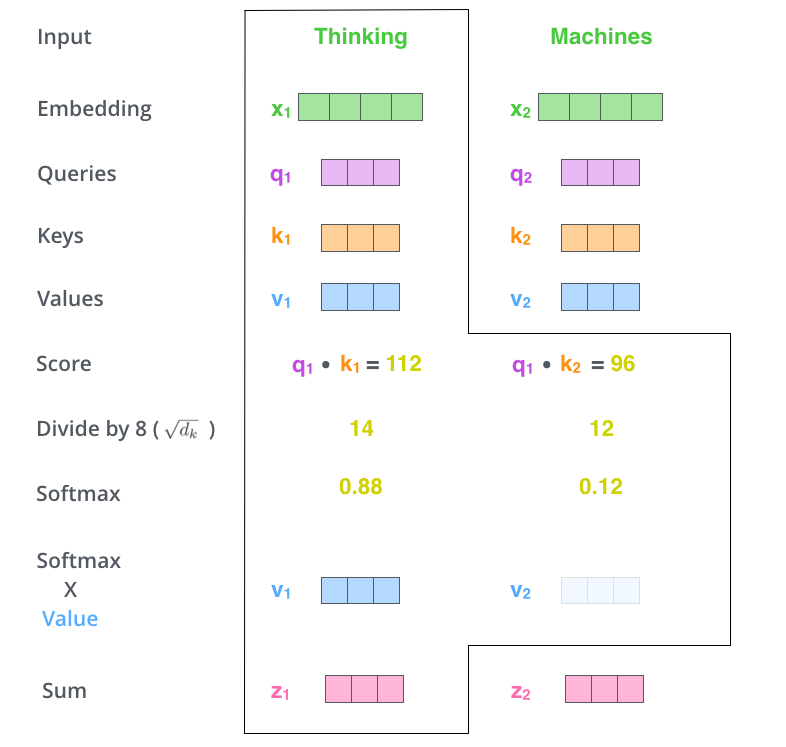

 This calculation is done in matrix form for faster processing

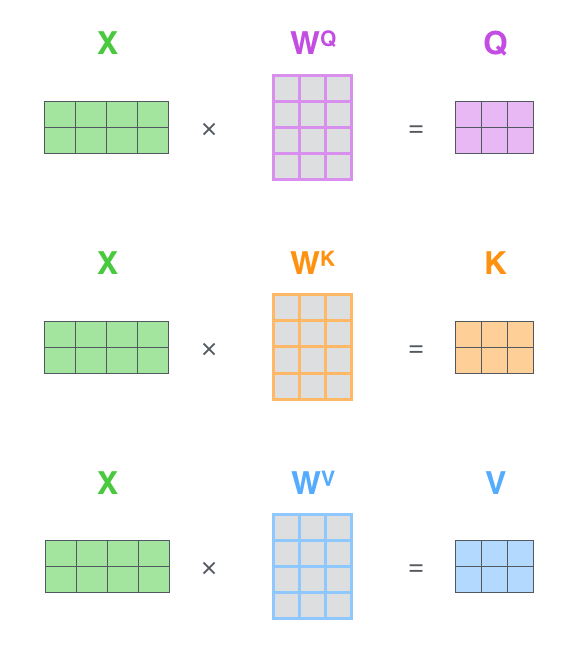

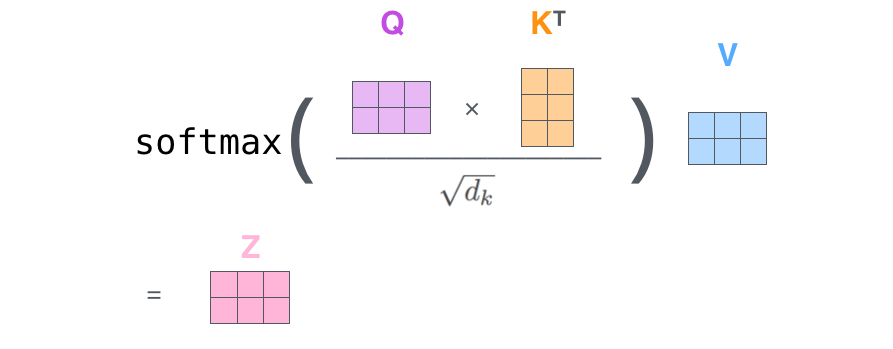

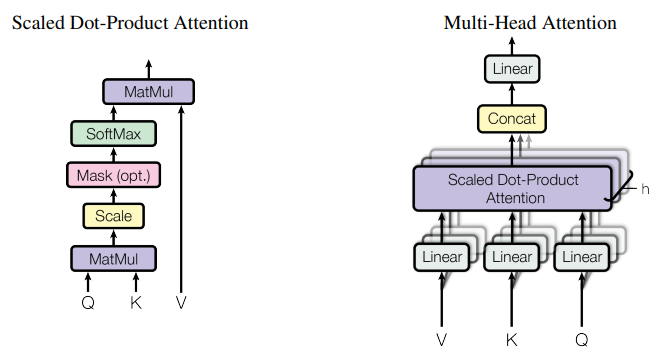

### Visualize Attention in NLP Models - BertViz

#### Init

In [ ]:
# Init
model_type = 'bert'
model_version = 'bert-base-uncased'
sentence_a = "the rabbit quickly hopped"
sentence_b = "The turtle slowly crawled"

In [ ]:
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']

attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist()  # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

#### Head View


<b>The head view visualizes attention in one or more heads from a single Transformer layer.</b> Each line shows the attention from one token (left) to another (right). Line weight reflects the attention value (ranges from 0 to 1), while line color identifies the attention head. When multiple heads are selected (indicated by the colored tiles at the top), the corresponding  visualizations are overlaid onto one another.  For a more detailed explanation of attention in Transformer models, please refer to the [blog](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1).

##### Usage


👉 **Hover** over any **token** on the left/right side of the visualization to filter attention from/to that token. <br/>
👉 **Double-click** on any of the **colored tiles** at the top to filter to the corresponding attention head.<br/>
👉 **Single-click** on any of the **colored tiles** to toggle selection of the corresponding attention head. <br/>
👉 **Click** on the **Layer** drop-down to change the model layer (zero-indexed).

In [ ]:
head_view(attention, tokens, sentence_b_start)

#### Neuron View

<b>The neuron view visualizes the intermediate representations (e.g. query and key vectors) that are used to compute attention.</b> In the collapsed view (initial state), the lines show the attention from each token (left) to every other token (right). In the expanded view, the tool traces the chain of computations that produce these attention weights. For a detailed explanation of the attention mechanism, please refer to the [blog](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1).

##### Usage



👉 **Hover** over any of the tokens on the left side of the visualization to filter attention from that token.<br/>
👉 Then **click** on the **plus** icon that is revealed when hovering. This exposes the query vectors, key vectors, and other intermediate representations used to compute the attention weights. Each color band represents a single neuron value, where color intensity indicates the magnitude and hue the sign (blue=positive, orange=negative).<br/>
👉 Once in the expanded view, **hover** over any other **token** on the left to see the associated attention computations.<br/>
👉 **Click** on the **Layer** or **Head** drop-downs to change the model layer or head (zero-indexed).

In [ ]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)
show(model, model_type, tokenizer, sentence_a, sentence_b, layer=4, head=3)

#### Self-Attention vs Recurrent Layer


1. attention vs recurrence = graph vs sequence = Transformer vs LSTM
2. attention connects across entire sequence as fully connected graph
3. RRNs keeps information from previous states in a state vector as a memory
4. RRNs not parallelizable in time dimension as future steps depend on the past
5.  RRNs have difficulty accessing long time ago information

#### Attention vs Self-Attention


1.  In neural networks you have inputs before layers, activations (outputs) of the layers and in RNN you have states of the layers. If Attention is used at some layer - the attention looks to (i.e. takes input from) the activations or states of some other layer. If Self-Attention is applied - the attention looks at the inputs of the same layer where it's applied.

2.  Attention is often applied to transfer information from encoder to decoder. I.e. decoder neurons receive addition input (via Attention) from the encoder states/activations. So in this case Attention connects 2 different components - encoder and decoder. If Self-Attention is applied - it doesn't connect 2 different components, it's applied within one component. There may be no decoder at all if you use Self-Attention, as for example in BERT architecture.

3.  Self-Attention may be applied many times independently within a single model (e.g. 18 times in Transformer, 12 times in BERT BASE) while Attention is usually applied once in the model and connects some 2 components (e.g. encoder and decoder).

4.  Self-Attention is good at modeling dependencies between different parts of the sequence. For example - understand the syntactic function between words in the sentence. Attention on the other hand models only the dependencies between 2 different sequences (for example, the original text and the translation of the text). While still the Self-Attention may be very good in translation task (see Transformer)

5.  Attention can connect 2 different modalities (i.e. text and image). Self-Attention is usually applied within a single modality but you still can join activations from 2 modalities into a single sequence and apply Self-Attention on it.

6.  Generally Self-Attention mechanism looks like a more general to me as it can do more than Attention. You can simulate Attention with Self-Attention by just replacing/concatenating the input sequence with the target sequence that you want your attention to look at.

## Tokenization


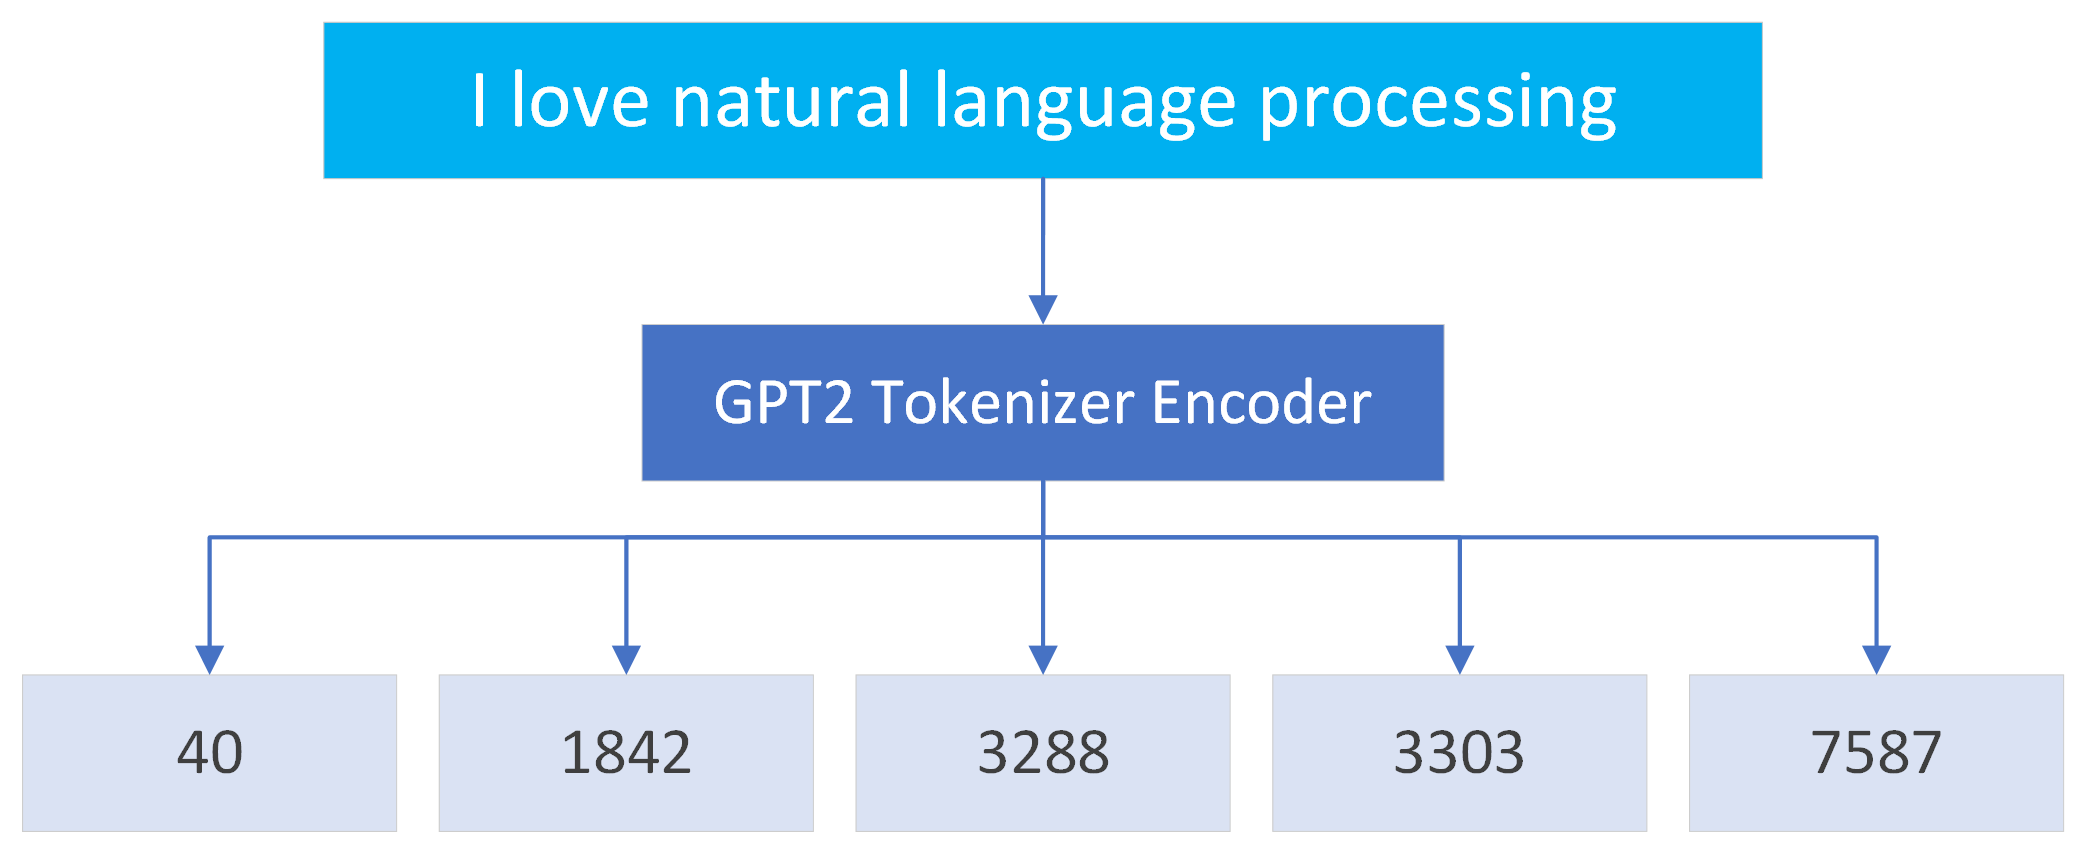

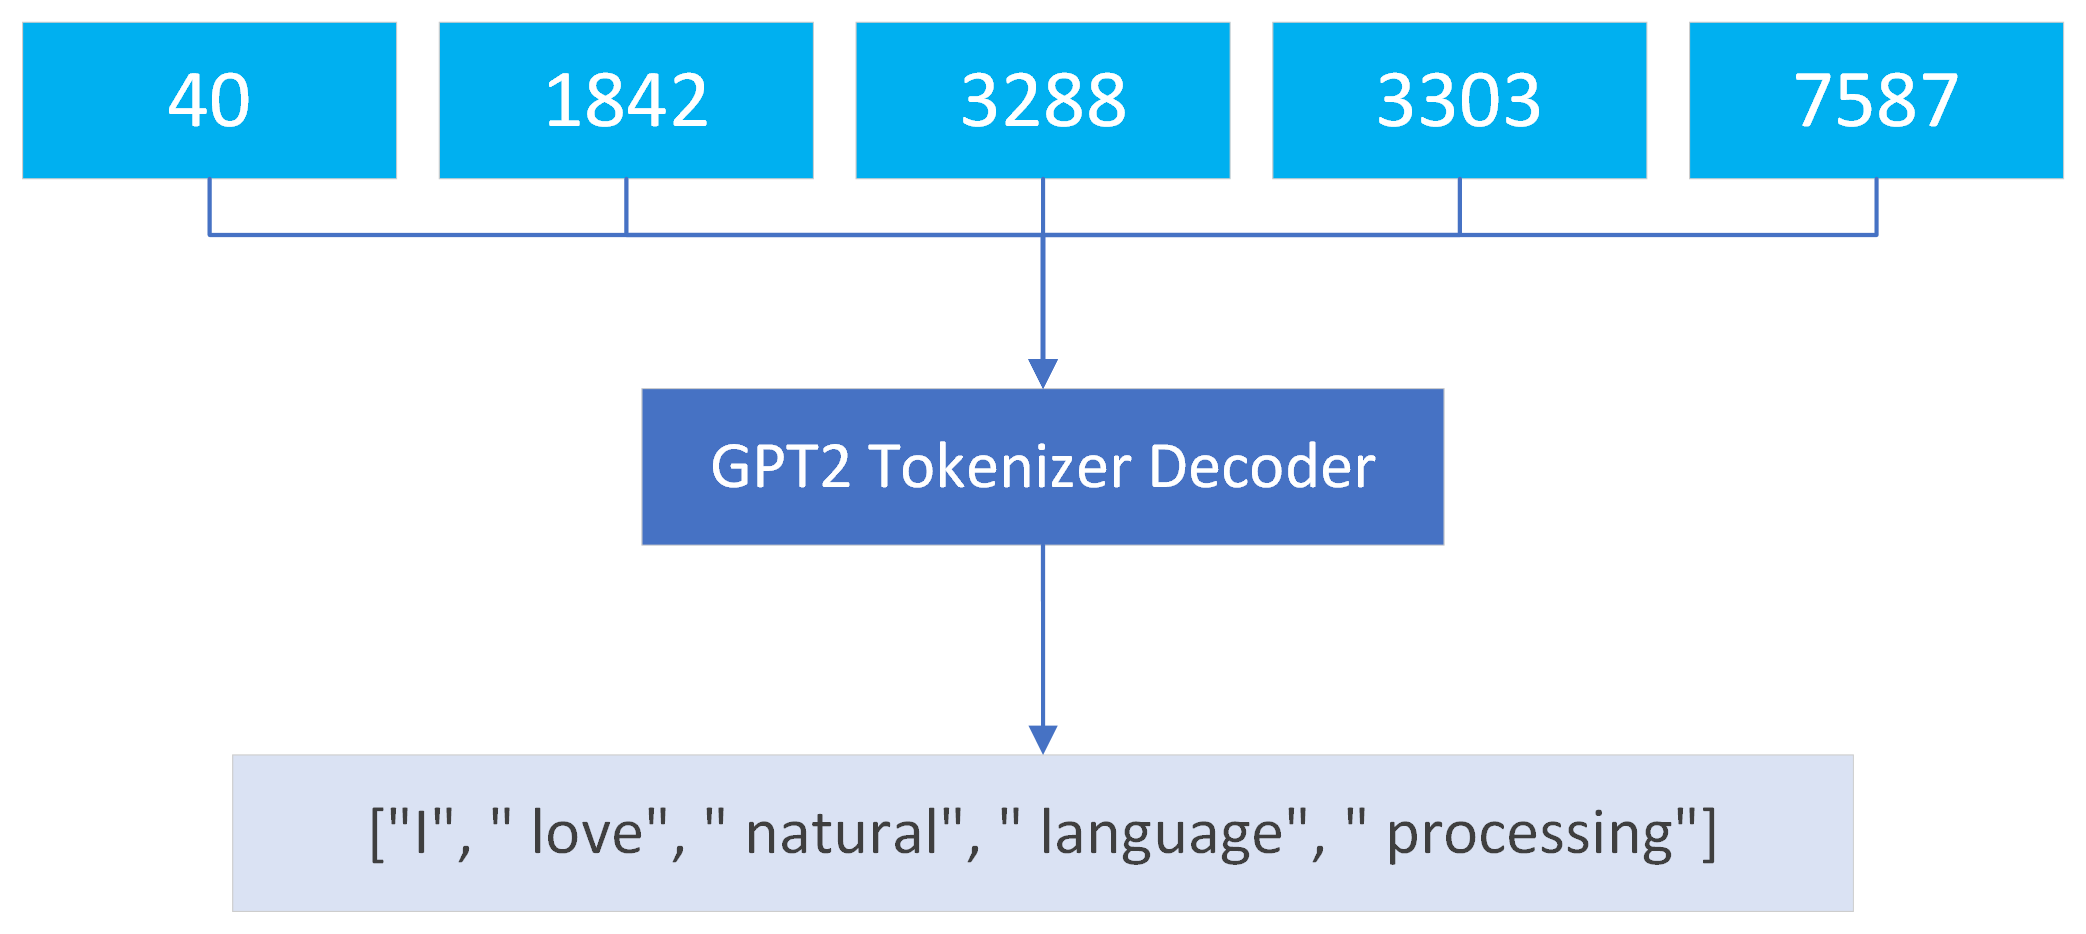

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer("Using a Transformer network is simple.")

In [ ]:
sequence = "Using a Transformer network is simple."
tokens = tokenizer.tokenize(sequence)
print(f"Tokens: {tokens}")
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"IDs: {ids}")
decoded_string = tokenizer.decode(ids)
print(f"Decoded: {decoded_string}")

In [ ]:
len(tokenizer)

\* Tokens IDs are not embedding

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
tokens = tokenizer.encode(sequence, return_tensors='pt')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
embeddings = model.embeddings.word_embeddings(tokens)[0]
print(f"We got {len(embeddings)} embedding tesnors")
print(f"Each of size {len(embeddings[0])}")
print(f"For example {embeddings[0]}")

## Model Types

### Encoder Models

Encoder models use only the encoder of a Transformer model. At each stage, the attention layers can access all the words in the initial sentence. These models are often characterized as having “bi-directional” attention, and are often called auto-encoding models.

The pretraining of these models usually revolves around somehow corrupting a given sentence (for instance, by masking random words in it) and tasking the model with finding or reconstructing the initial sentence.

Encoder models are best suited for tasks requiring an understanding of the full sentence, such as sentence classification, named entity recognition (and more generally word classification), and extractive question answering.

### Decoder Models

Decoder models use only the decoder of a Transformer model. At each stage, for a given word the attention layers can only access the words positioned before it in the sentence. These models are often called auto-regressive models.

The pretraining of decoder models usually revolves around predicting the next word in the sentence.

These models are best suited for tasks involving text generation.

### Encoder-decoder Models

Encoder-decoder models (also called sequence-to-sequence models) use both parts of the Transformer architecture. At each stage, the attention layers of the encoder can access all the words in the initial sentence, whereas the attention layers of the decoder can only access the words positioned before a given word in the input.

The pretraining of these models can be done using the objectives of encoder or decoder models, but usually involves something a bit more complex. For instance, T5 is pretrained by replacing random spans of text (that can contain several words) with a single mask special word, and the objective is then to predict the text that this mask word replaces.

Sequence-to-sequence models are best suited for tasks revolving around generating new sentences depending on a given input, such as summarization, translation, or generative question answering.

### Models Catalog

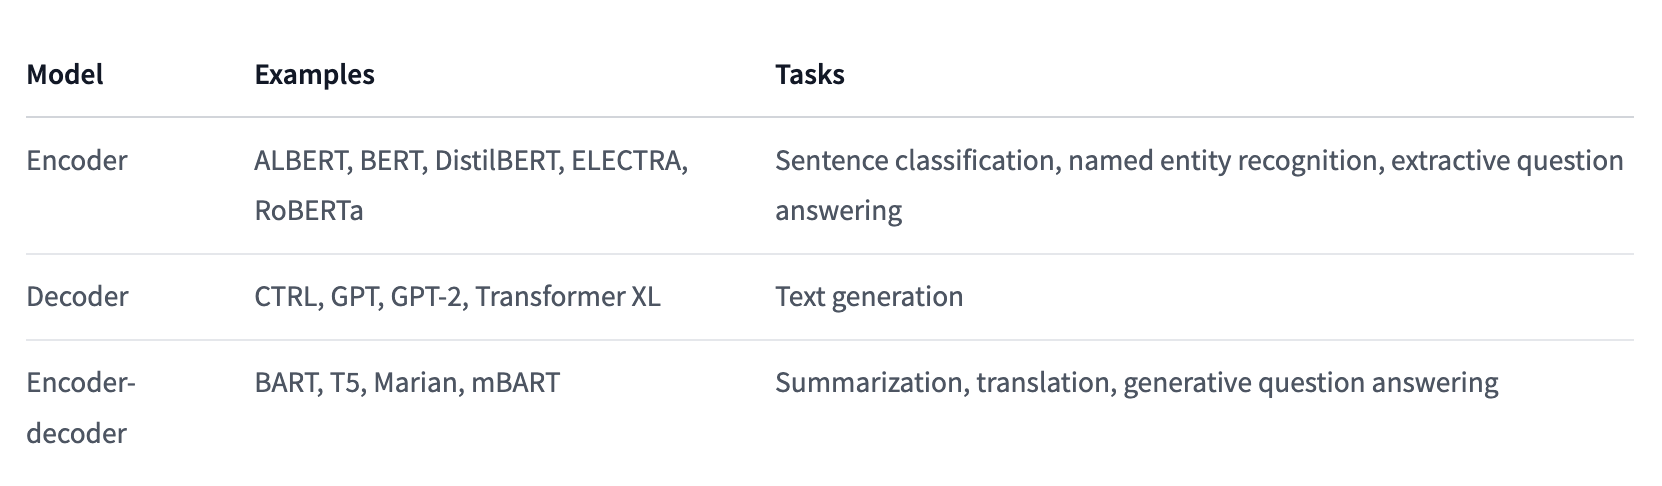

## Deeper Look in GPT2


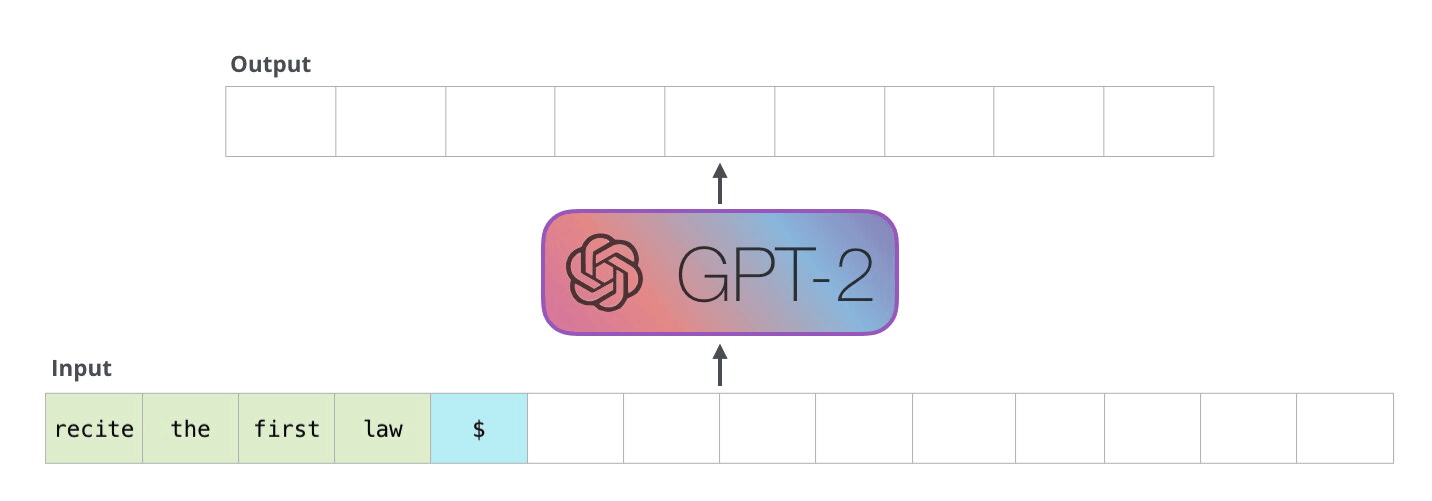

https://github.com/huggingface/transformers/blob/ab9fe45236cd99b8797df78219438f8f6662bb42/src/transformers/models/gpt2/modeling_gpt2.py#L667

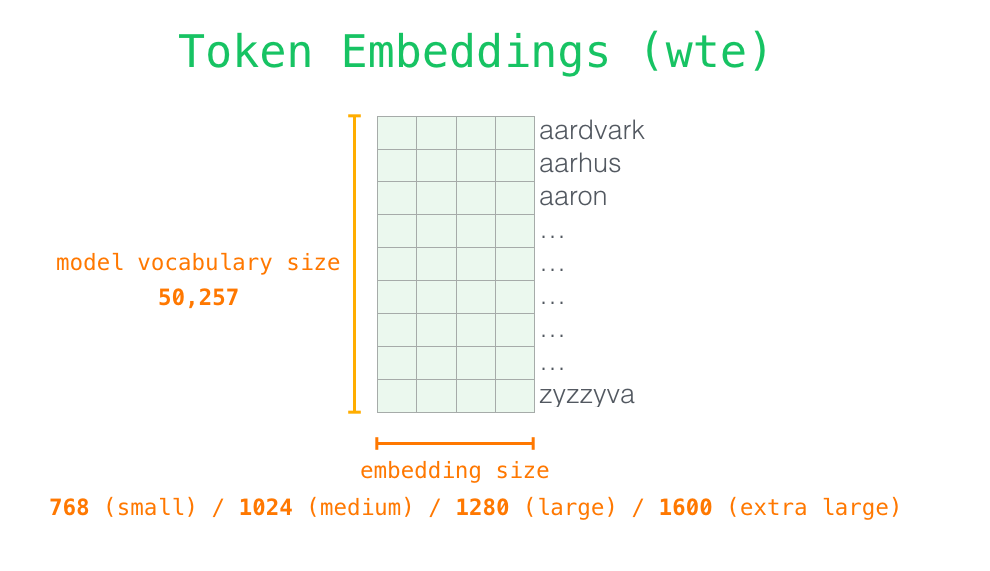

Each row is a word embedding: a list of numbers representing a word and capturing some of its meaning.

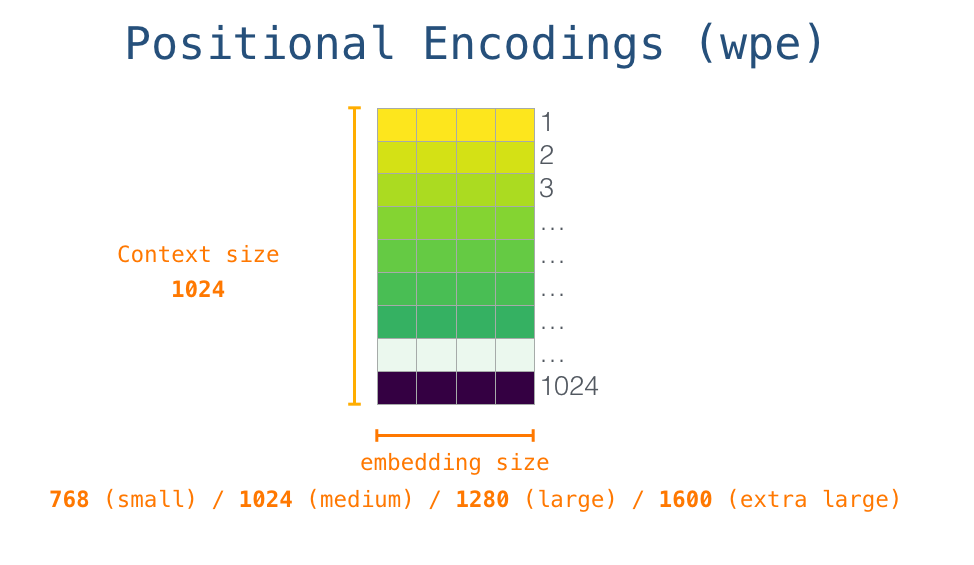

    GPT2LMHeadModel(
    (transformer): GPT2Model(

    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      .
      .
      .
      .
      .
      (23): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    
    (lm_head): Linear(in_features=1024, out_features=50257, bias=False))

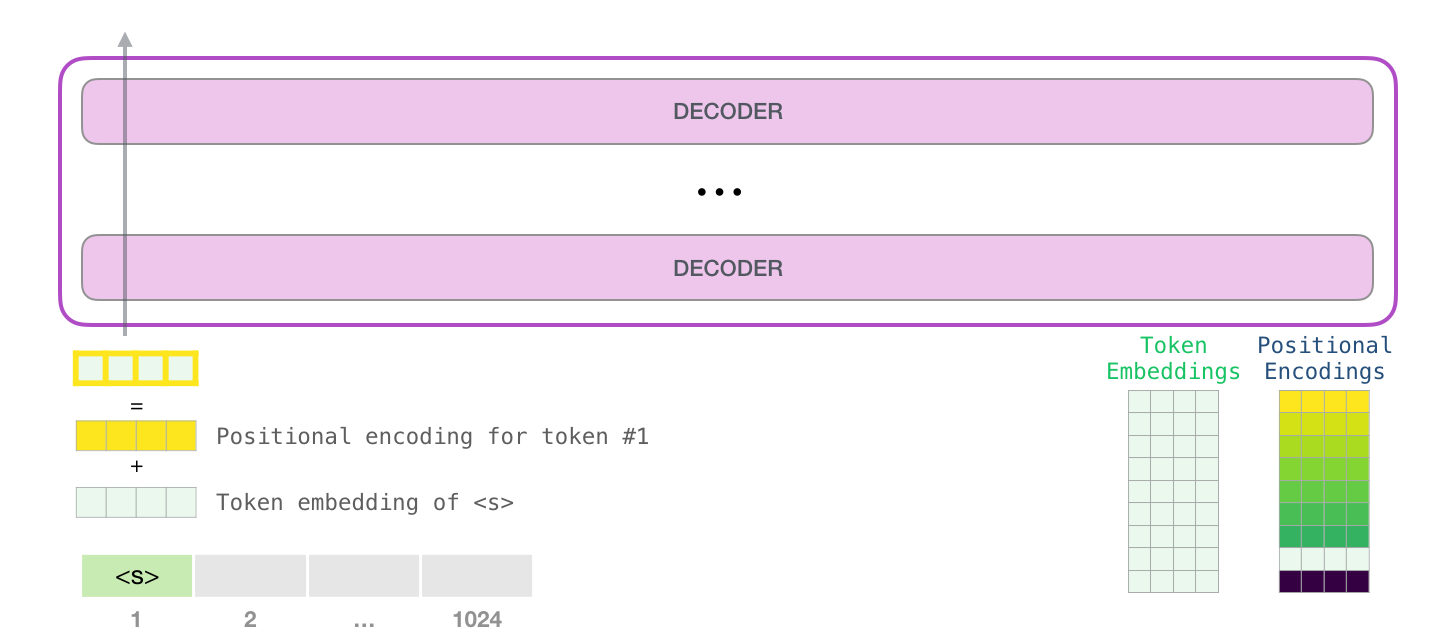

We look up the embedding of the start token \<s> in the embedding matrix. Before handing that to the first block in the model, we need to incorporate positional encoding – a signal that indicates the order of the words in the sequence to the transformer blocks. Part of the trained model is a matrix that contains a positional encoding vector for each of the 1024 positions in the input.

In forward propagation (also referred to as forward pass) we pass the input
from the first layer to the second layer and so on, until we reach the last layer.
More specifically, tokenized input goes through the embedding layer (the first
layer), which enables us to convert each token into a fixed dimension vector. Then, the embedded input goes through model's blocks. Each block
contains an attention layer and a fully connected layer with a Gaussian
Error Linear Unit (GELU) as the activation function. GELU proved to be
a high-performing neural network activation function, 

$GELU(x) = 0.5 \cdot x (1+\tanh{[\sqrt{\frac{2}{\pi}}(x+0.044715x^{3})]})$

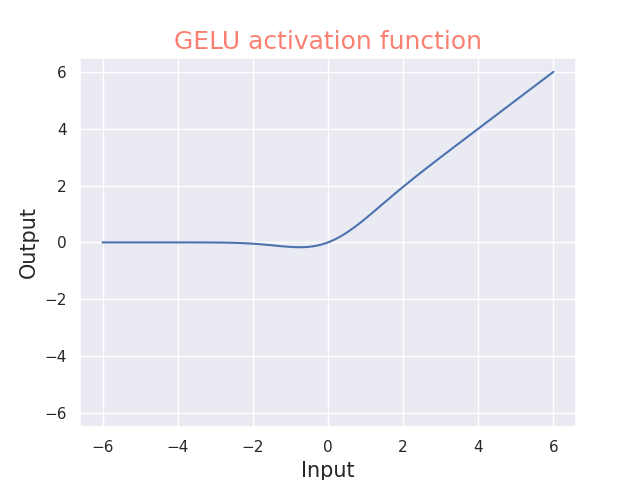

# Training

Cross entropy loss is a metric used to measure how well a classification model in machine learning performs. The loss (or error) is measured as a number between 0 and 1, with 0 being a perfect model. The goal is generally to get your model as close to 0 as possible.

in the case of Binary Classification, cross-entropy is given by:

$ l = -(y\log{(p)}+(1 - y)log({1-p}))) $

In our case we need multi class classification (vocabulary size),

$ -\sum_{c=1}^{N}{y_{c}log{(p_{c})}} $

## Training objectives

When training a model we need to define a task for the model to learn on. Some of the typical tasks, such as predicting the next word or learning to reconstruct masked words were already mentioned above. “Pre-trained Models for Natural Language Processing: A Survey” includes a pretty comprehensive taxonomy of pretraining tasks, all of which can be considered self-supervised:

1.  Language Modeling (LM): Predict next token (in the case of unidirectional LM) or previous and next token (in the case of bidirectional LM)

2.  Masked Language Modeling (MLM): mask out some tokens from the input sentences and then trains the model to predict the masked tokens by the rest of the tokens
3.  Permuted Language Modeling (PLM): same as LM but on a random permutation of input sequences. A permutation is randomly sampled from all possible permutations. Then some of the tokens are chosen as the target, and the model is trained to predict these targets.
4.  Denoising Autoencoder (DAE): take a partially corrupted input (e.g. Randomly sampling tokens from the input and replacing them with [MASK] elements. randomly deleting tokens from the input, or shuffling sentences in random order) and aim to recover the original undistorted input.
5.  Contrastive Learning (CTL): A score function for text pairs is learned by assuming some observed pairs of text that are more semantically similar than randomly sampled text. It includes: Deep InfoMax (DIM): maximize mutual information between an image representation and local regions of the image; Replaced Token Detection (RTD): predict whether a token is replaced given its surroundings; Next Sentence Prediction (NSP): train the model to distinguish whether two input sentences are continuous segments from the training corpus; and Sentence Order Prediction (SOP): Similar to NSP, but uses two consecutive segments as positive examples, and the same segments but with their order swapped as negative examples


## Pretraining

Pretraining is the act of training a model from scratch: the weights are randomly initialized, and the training starts without any prior knowledge.

For example let's take **Codex** which is a descendant of GPT-3.

Its training data contains both natural language and billions of lines of source code from publicly available sources, including code in public GitHub repositories.

## Fine Tuning

Lets fine tune GPT2 to generate jokes

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
_tokenizer: GPT2Tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

_model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
_model = _model.to('cuda' if torch.cuda.is_available() else 'cpu')
_model.device

In [ ]:
# noinspection SpellCheckingInspection
class JokesDataset(Dataset):
    def __init__(self, jokes_dataset_folder: str, filename: str):
        super().__init__()

        short_jokes_path = os.path.join(jokes_dataset_folder, filename)
        with open(short_jokes_path) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            self.joke_list: List[str] = [f'JOKE:{row[1]}"<|endoftext|>"' for row in csv_reader]

    def __len__(self) -> int:
        return len(self.joke_list)

    def __getitem__(self, item) -> str:
        return self.joke_list[item]

In [ ]:
_jokes_folder = ''
_dataset_train = JokesDataset(jokes_dataset_folder=_jokes_folder, filename='shortjokes_train.csv')
_dataset_test = JokesDataset(jokes_dataset_folder=_jokes_folder, filename='shortjokes_test.csv')

_joke_dataloader_train = DataLoader(dataset=_dataset_train, shuffle=True)
_joke_dataloader_test = DataLoader(dataset=_dataset_test, shuffle=True)

In [ ]:
@dataclass()
class TrainArguments:
    batch_size: int = 16
    epochs: int = 5
    learning_rate: float = 3e-5
    warmup_steps: int = 5000
    max_prompt_length: int = 400

In [ ]:
def train_model(model: GPT2LMHeadModel, tokenizer: GPT2Tokenizer,
                jokes_ds_loader_train: DataLoader, train_args: TrainArguments, jokes_ds_loader_test: DataLoader):
    model.train()
    optimizer = AdamW(model.parameters(), lr=train_args.learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=train_args.warmup_steps,
                                                num_training_steps=-1)

    tensor_prompt_jokes = None
    models_folder = "trained_models"
    if not os.path.exists(models_folder):
        os.mkdir(models_folder)

    batch_counter = 0
    for epoch in range(train_args.epochs):
        print(f'######### Epoch {epoch + 1} #########')

        log_losses, log_perp, log_perp_test = [], [], []
        batches_completed_counter = -1
        for joke in tqdm(jokes_ds_loader_train):
            #region Fit as many jokes as we can until its surpass our prompt length limit
            tensor_joke = torch.tensor(tokenizer.encode(joke[0])).unsqueeze(0).to(model.device)
            if tensor_joke.size()[
                1] > train_args.max_prompt_length:  # Joke is greater than our prompt length limit, then we skip it.
                continue

            #The first joke sequence in the sequence
            if not torch.is_tensor(tensor_prompt_jokes):
                tensor_prompt_jokes = tensor_joke
                continue
            else:
                if tensor_prompt_jokes.size()[1] + tensor_joke.size()[
                    1] > train_args.max_prompt_length:  # Check if we can add current joke to our prompt.
                    tensor_prompt_jokes_ready = tensor_prompt_jokes
                    tensor_prompt_jokes = tensor_joke
                else:
                    tensor_prompt_jokes = torch.cat([tensor_prompt_jokes, tensor_joke[:, 1:]],
                                                    dim=1)  # Add the joke horizontally.
                    continue
            #endregion

            outputs: CausalLMOutputWithCrossAttentions = model(tensor_prompt_jokes_ready,
                                                               labels=tensor_prompt_jokes_ready)  # Process prompt through the model.

            # noinspection SpellCheckingInspection
            loss, logits = outputs.loss, outputs.logits
            loss.backward()  # do gradient of all parameters for which we set required_grad= True
            log_losses.append(float(loss.detach().data))
            log_perp.append(float(torch.exp(loss)))

            batch_counter += 1
            if batch_counter == train_args.batch_size:  # This step can be done in one iteration if we insert 16 samples to the model at once, due to small GPUs we are doing it one at a time.
                batch_counter = 0

                optimizer.step()  # We update parameters to finally get the minimum loss (according AdamW)
                scheduler.step()

                optimizer.zero_grad()
                model.zero_grad()

                batches_completed_counter += 1

            if batches_completed_counter == 50 or batches_completed_counter == -1:
                batches_completed_counter = 0
                log_p = []
                tensor_prompt_jokes_test = None
                for joke_test in jokes_ds_loader_test:
                    tensor_joke_test = torch.tensor(tokenizer.encode(joke_test[0])).unsqueeze(0).to(model.device)
                    if tensor_joke_test.size()[
                        1] > train_args.max_prompt_length:  # Joke is greater than our prompt length limit, then we skip it.
                        continue

                    #The first joke sequence in the sequence
                    if not torch.is_tensor(tensor_prompt_jokes_test):
                        tensor_prompt_jokes_test = tensor_joke
                        continue
                    else:
                        if tensor_prompt_jokes_test.size()[1] + tensor_joke_test.size()[
                            1] > train_args.max_prompt_length:  # Check if we can add current joke to our prompt.
                            tensor_prompt_jokes_ready_test = tensor_prompt_jokes_test
                            tensor_prompt_jokes_test = tensor_joke_test
                        else:
                            tensor_prompt_jokes_test = torch.cat([tensor_prompt_jokes_test, tensor_joke_test[:, 1:]],
                                                                 dim=1)  # Add the joke horizontally.
                            continue
                    #endregion

                    outputs: CausalLMOutputWithCrossAttentions = model(tensor_prompt_jokes_ready_test,
                                                                       labels=tensor_prompt_jokes_ready_test)  # Process prompt through the model.
                    loss, logits = outputs.loss, outputs.logits
                    log_perp_test.append(float(torch.exp(loss)))

                log_perp_test.append(float(np.mean(log_perp_test)))
                # print(log_perp_test[-1])

                optimizer.zero_grad()
                model.zero_grad()

        with open(os.path.join(models_folder, f'gpt2_medium_joker_{epoch}_loss.log'), 'w') as log_handle:
            log_handle.write(','.join([str(num) for num in log_losses]))
        with open(os.path.join(models_folder, f'gpt2_medium_joker_{epoch}_perplexity.log'), 'w') as log_handle:
            log_handle.write(','.join([str(num) for num in log_perp]))
        with open(os.path.join(models_folder, f'gpt2_medium_joker_{epoch}_perplexity_test.log'), 'w') as log_handle:
            log_handle.write(','.join([str(num) for num in log_perp_test]))

        model_saving_filename = os.path.join(models_folder, f'gpt2_medium_joker_{epoch}.pt')
        torch.save(_model.state_dict(), model_saving_filename)  # Saving model's weights

        sns.lineplot(data=log_losses, label='Loss')
        plt.xlabel('Iteration', fontsize=15)
        plt.suptitle(f'Loss Train Dataset- Epoch {epoch + 1}', fontsize=22, color='salmon')
        plt.legend()
        plt.show()

        sns.lineplot(data=log_perp, label='Perplexity')
        plt.xlabel('Iteration', fontsize=15)
        plt.suptitle(f'Perplexity Train Dataset - Epoch {epoch + 1}', fontsize=22, color='salmon')
        plt.legend()
        plt.show()

        sns.lineplot(data=log_perp_test, label='Perplexity')
        plt.xlabel('Iteration', fontsize=15)
        plt.suptitle(f'Perplexity Test Dataset - Epoch {epoch + 1}', fontsize=22, color='salmon')
        plt.legend()
        plt.show()

In [ ]:
train_model(model=_model, tokenizer=_tokenizer, jokes_ds_loader_train=_joke_dataloader_train,
            train_args=TrainArguments(epochs=3),
            jokes_ds_loader_test=_joke_dataloader_test)

In [ ]:
# noinspection SpellCheckingInspection
def choose_from_top(softmax_logits: torch.Tensor, top_k: int = 20) -> int:
    """
    Example:

        softmax_logits = [0.1, 0.4, 0.3, 0.2]
        logits_sorted_desc = [1, 2, 3, 0]
        top_indices = logits_sorted_desc[:top k] --> [1, 2, 3, 0]

        top_logits = [0.4, 0.3, 0.2, 0.1]
        top_logits = [0.4, 0.3, 0.2, 0.1] Normalized (Nothing changed because top_k > 4)

        chose one index (probabilities=top_logits)

        retrive token id and retirn it.
    """

    logits_sorted_desc = torch.argsort(softmax_logits, descending=True)
    top_indices = logits_sorted_desc[:top_k]

    top_logits = softmax_logits[top_indices].cpu().numpy()
    top_logits = top_logits / np.sum(top_logits)

    prob_chosen = float(np.random.choice(a=top_logits, size=1, p=top_logits)[0])
    chosen_token_idx = np.where(top_logits == prob_chosen)[0]

    return int(logits_sorted_desc[chosen_token_idx])


# noinspection SpellCheckingInspection
def generate_joke(model: GPT2LMHeadModel, tokenizer: GPT2Tokenizer, prompt: str = 'JOKE:') -> str:
    tensor_prompt_joke = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to(_device)
    with torch.no_grad():
        for i in range(30):
            outputs: CausalLMOutputWithCrossAttentions = model(tensor_prompt_joke,
                                                               labels=tensor_prompt_joke)  # Process prompt through the model.

            # noinspection SpellCheckingInspection
            loss, logits = outputs.loss, outputs.logits
            softmax_logits = torch.softmax(logits[0, -1], dim=0)
            next_token_id = choose_from_top(softmax_logits=softmax_logits, top_k=(20 if i < 3 else 5))
            tensor_next_token_id = torch.tensor(data=[[next_token_id]], dtype=torch.int64, device=model.device)

            tensor_prompt_joke = torch.cat([tensor_prompt_joke, tensor_next_token_id], dim=1)

            if next_token_id == tokenizer.eos_token_id:
                break

        return tokenizer.decode(tensor_prompt_joke.squeeze().cpu())

In [ ]:
_model_chosen = 0

_models_folder = "trained_models"

_model_path = os.path.join(_models_folder, f"gpt2_medium_joker_{_model_chosen}.pt")
_model.load_state_dict(torch.load(_model_path))
_model.eval()  # Set model as evaluation mode.

In [ ]:
generate_joke(model=_model, tokenizer=_tokenizer)

## Prompt Engineering

In prompt engineering, the description of the task is embedded in the input, e.g., as a question instead of it being implicitly given. Prompt engineering typically works by converting one or more tasks to a prompt-based dataset and training a language model with what has been called "prompt-based learning" or just "prompt learning". Prompt engineering may work from a large "frozen" pretrained language model and where only the representation of the prompt is learned, with what has been called "prefix-tuning" or "prompt tuning".

Prompts that include a train of thought in few-shot learning examples show better indication of reasoning in language models. In zero-shot learning prepending text to the prompt that encourages a chain of thought (e.g. "Let's think step by step") may improve the performance of a language model in multi-step reasoning problems.

# More Examples

### Training

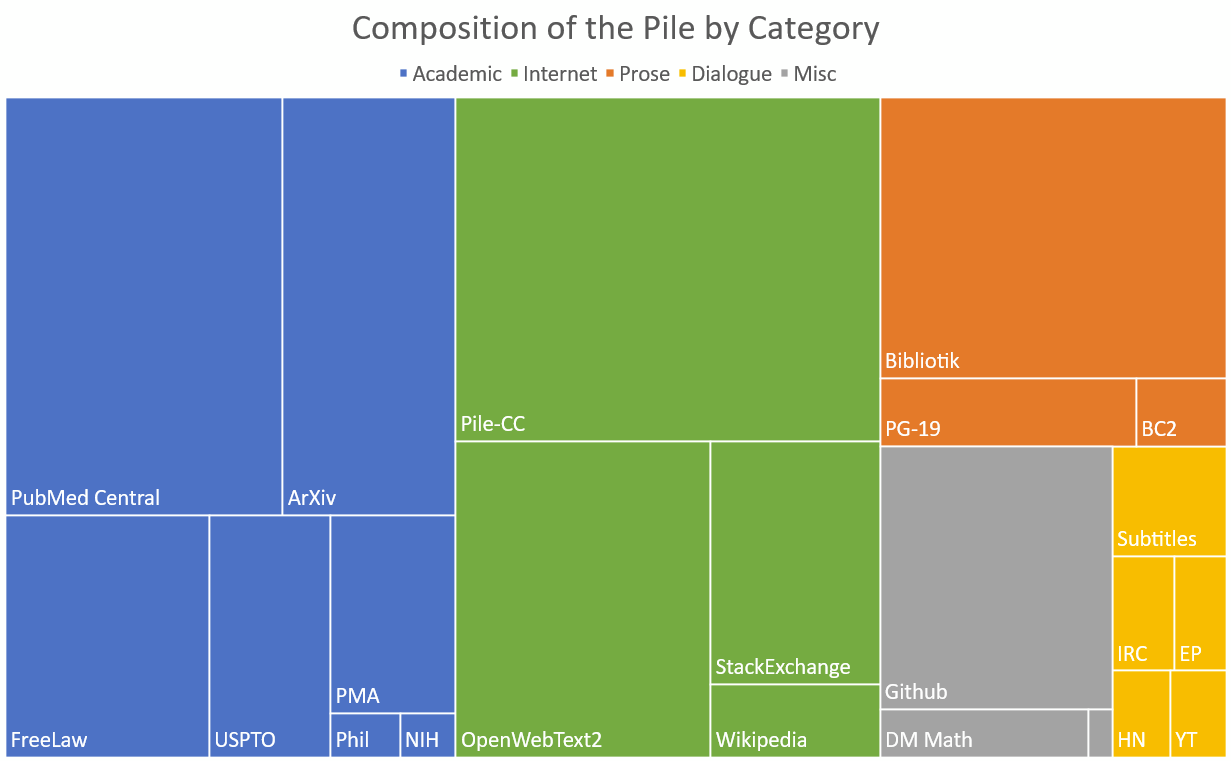

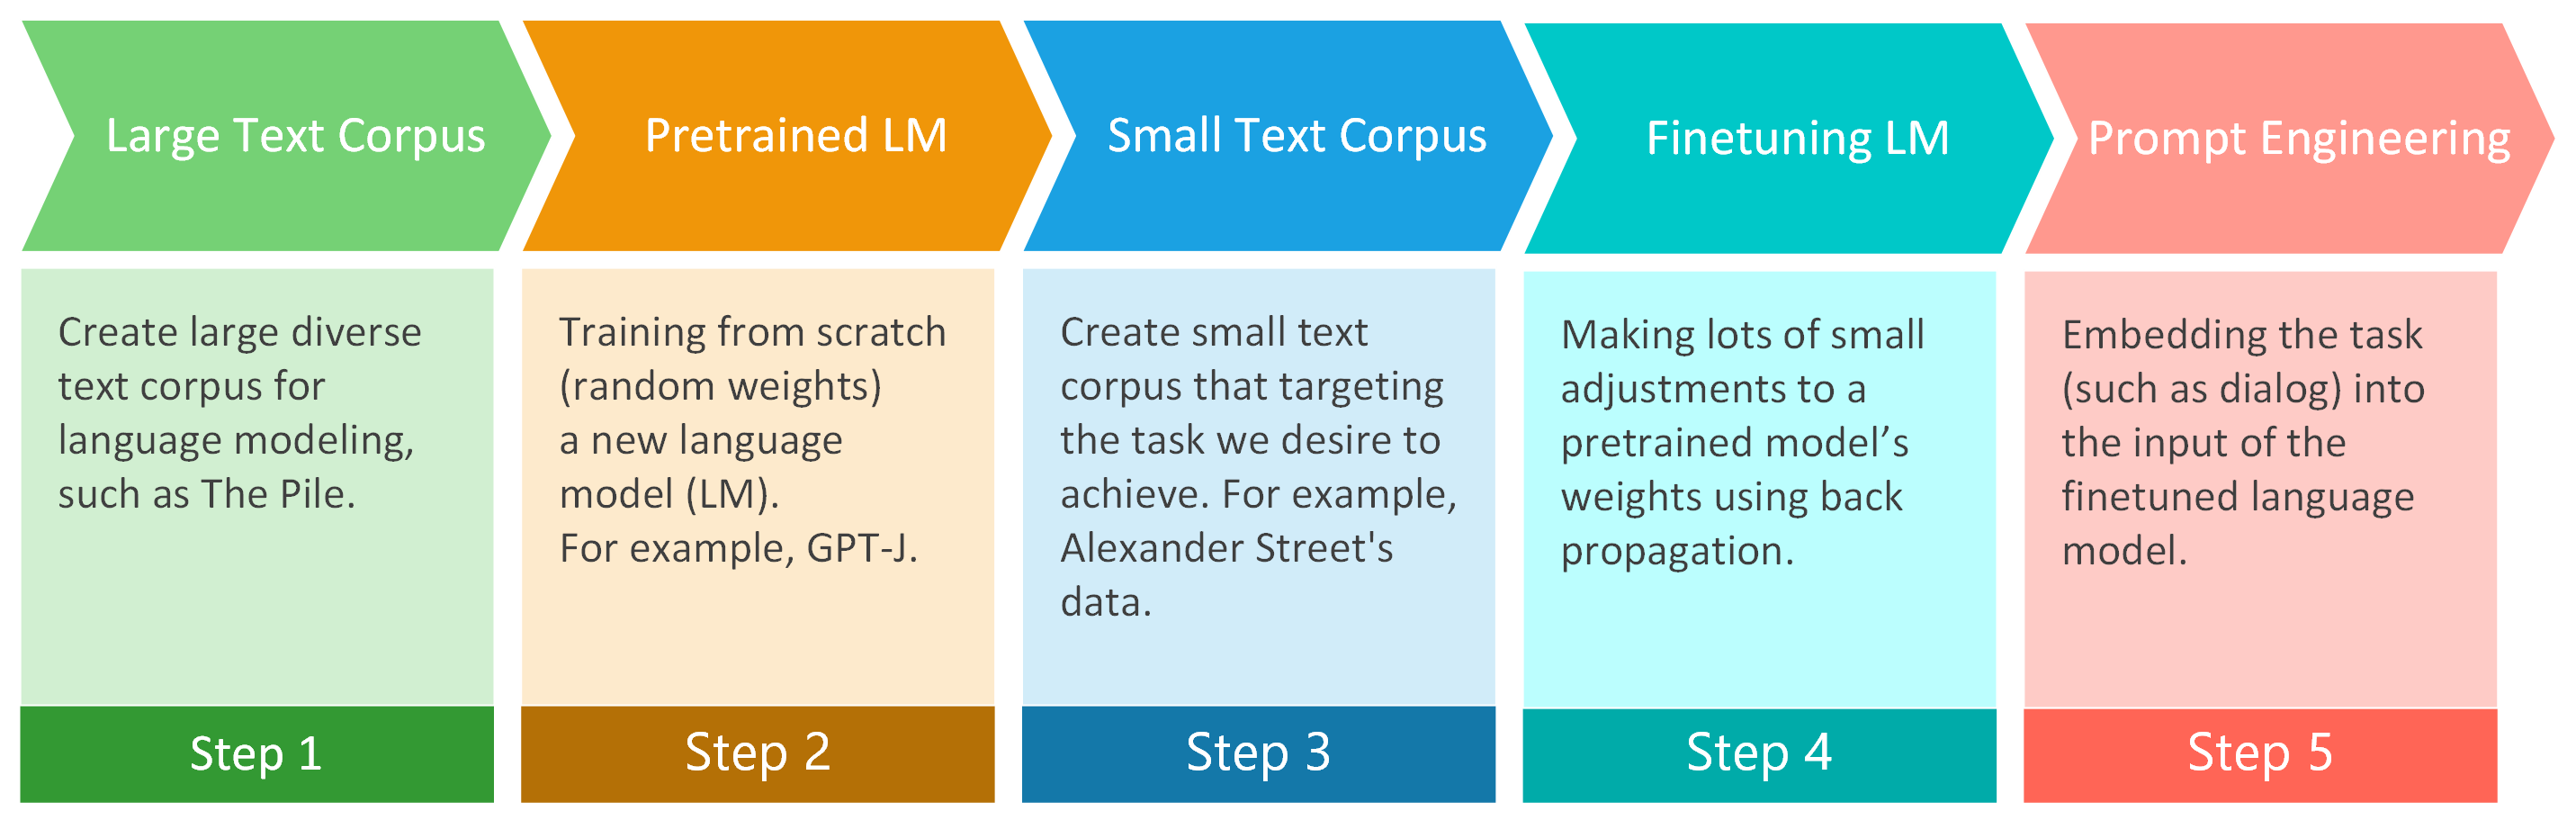

## DeepSpeed

GPT-J contains 6B parameters which is around 22GB of memory to load, therefore to finetuned such big model we need almost 100GB of GPU! there isn't gpu with 100GB then Microsoft's DeepSpeed takes a big part in todays training.

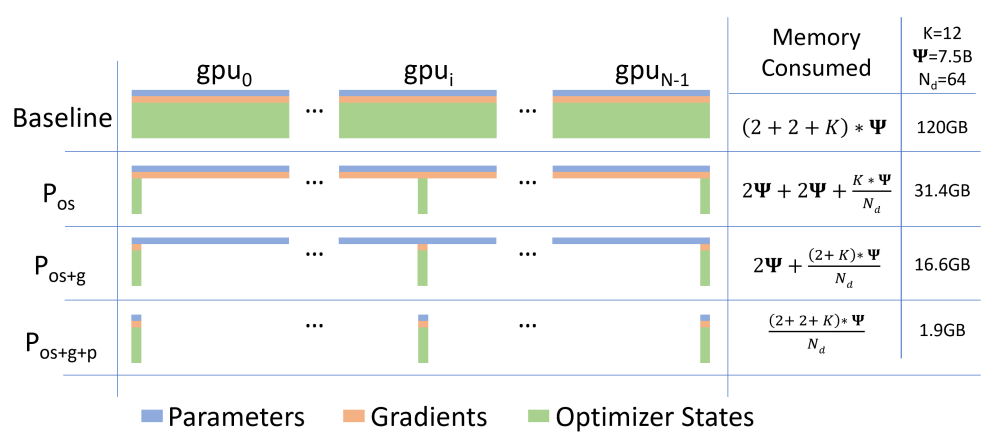

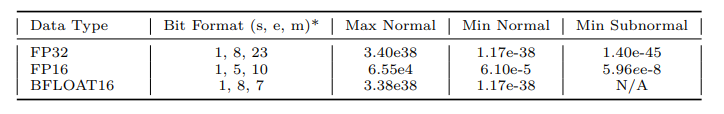

https://tipul.herokuapp.com/new_participant or https://tinyurl.com/IDCTipul

### Few-shot learning 

This is a sentiment classifier.
"I loved this movie!" positive.
"I don't know, it was ok I guess..." neutral.
"What a waste of time, would not recommend this movie." negative.
"I really enjoyed this movie!" 

https://playground.helloforefront.com/models/free-gpt-j-playground

# More Info

There is lots of information about this topic online and we encourage you to look and further learn for yourself. We used the following in the making of this workshop:
1. https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
2. https://jalammar.github.io/illustrated-transformer/
3. https://jalammar.github.io/illustrated-gpt2/
4. https://github.com/jessevig/bertviz
5. https://huggingface.co/
6. https://nlpoverview.com/
7. https://vaclavkosar.com/ml/transformers-self-attention-mechanism-simplified
8. https://en.wikipedia.org/